## Functions

In [1]:
!pip install -q xgboost datasets matplotlib joblib scikit-learn scipy 

In [3]:
from utils import prepare_model_features
# ----------------------
# Prediction & Evaluation
# ----------------------

def make_predictions(model, df):
    """
    Make predictions using trained model.
    """
    X = prepare_model_features(df)
    predictions = model.predict(X)

    # Set predictions to 0 when location is closed
    predictions[df['is_open'] == 0] = 0

    return predictions

def calculate_metrics(actual, predicted):
    """
    Calculate model performance metrics.
    """
    return {
        'mae': mean_absolute_error(actual, predicted),
        'rmse': np.sqrt(mean_squared_error(actual, predicted))
    }

def plot_occupancy(dates, predictions, actual=None, location=""):
    """
    Plot predicted (and actual if available) occupancy.
    """
    plt.figure(figsize=(12, 6))

    if actual is not None:
        plt.plot(dates, actual, label="Actual", color="orange", alpha=0.7)
        title = f"Actual vs Predicted Occupancy - {location}"
    else:
        title = f"Predicted Occupancy - {location}"

    plt.plot(dates, predictions, label="Predicted", color="blue", alpha=0.7)
    plt.xlabel("Date")
    plt.ylabel("Occupancy")
    plt.title(title)
    plt.legend()
    plt.show()

In [4]:
def predict_future(models_dict, future_df):
    """
    Make future predictions for all locations.

    Args:
        models_dict: Dictionary of trained models
        future_df: DataFrame with future data
    Returns:
        DataFrame with predictions for all locations
    """
    results_df = future_df.copy()

    for location, model_info in models_dict.items():
        predictions = make_predictions(model_info['model'], future_df)
        results_df[f'{location}_predicted'] = predictions

        # Plot predictions
        plot_occupancy(future_df.index, predictions, location=location)

    return results_df

In [5]:
def load_models_from_huggingface(locations, repo_name, token):
    """
    Load models from Hugging Face.

    Args:
        locations: List of locations
        repo_name: Name of the Hugging Face repository
        token: Hugging Face API token
    Returns:
        dict: Dictionary containing loaded models
    """
    login(token=token)
    loaded_models = {}

    for location in locations:
        filename = f"xgboost_model_{location.replace(' ', '_')}.joblib"

        # Download the model file
        model_path = hf_hub_download(
            repo_id=repo_name,
            filename=filename,
            token=token
        )

        # Load the model
        model = joblib.load(model_path)
        loaded_models[location] = {'model': model}
        print(f"Model for {location} loaded successfully")

    return loaded_models

In [6]:
import pandas as pd
import numpy as np

def format_predictions(results_df, locations):
    """
    Format predictions into a clean DataFrame with datetime index and locations as columns.

    Args:
        results_df: DataFrame containing predictions
        locations: List of location names
    Returns:
        pd.DataFrame: Formatted predictions DataFrame
    """
    # Create a new DataFrame with datetime index
    formatted_df = pd.DataFrame(index=results_df.index)

    # Add predictions for each location
    for location in locations:
        # Get the predictions for this location
        pred_col = f'{location}_predicted'
        if pred_col in results_df.columns:
            formatted_df[location] = results_df[pred_col]
        else:
            print(f"Warning: No predictions found for {location}")

    # Sort index to ensure chronological order
    formatted_df = formatted_df.sort_index()

    # Round predictions to 2 decimal places
    formatted_df = formatted_df.round(2)

    return formatted_df

def predict_and_format(models_dict, future_df):
    """
    Make predictions and format them into a clean DataFrame.

    Args:
        models_dict: Dictionary of trained models
        future_df: DataFrame with future data
    Returns:
        pd.DataFrame: Formatted predictions DataFrame
    """
    # Get list of locations
    locations = list(models_dict.keys())

    # Make predictions for all locations
    results_df = future_df.copy()

    for location, model_info in models_dict.items():
        predictions = make_predictions(model_info['model'], future_df)
        results_df[f'{location}_predicted'] = predictions

    # Format predictions
    formatted_predictions = format_predictions(results_df, locations)

    return formatted_predictions

# 2. INFERENCE


### 2.1 Download the data


In [7]:
# Get the token from environment variables
import os


HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")


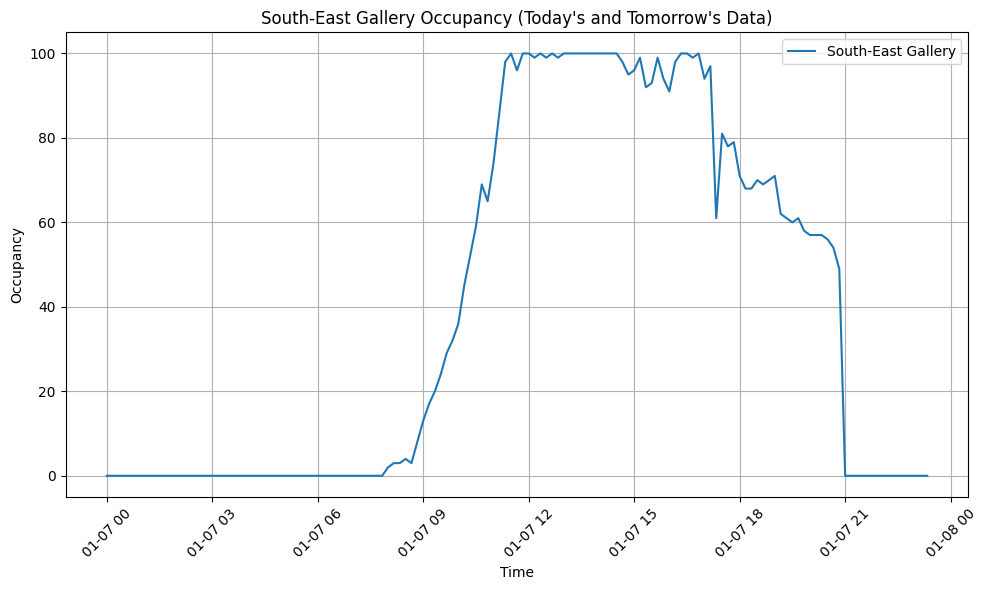

Downloaded Data (without NaN):
                     KTH Library  South-East Gallery  North Gallery  \
2025-01-07 22:40:00          0.0                 0.0            0.0   
2025-01-07 22:50:00          0.0                 0.0            0.0   
2025-01-07 23:00:00          0.0                 0.0            0.0   
2025-01-07 23:10:00          0.0                 0.0            0.0   
2025-01-07 23:20:00          0.0                 0.0            0.0   

                     South Gallery  Ångdomen  Newton  
2025-01-07 22:40:00            0.0       0.0     0.0  
2025-01-07 22:50:00            0.0       0.0     0.0  
2025-01-07 23:00:00            0.0       0.0     0.0  
2025-01-07 23:10:00            0.0       0.0     0.0  
2025-01-07 23:20:00            0.0       0.0     0.0  

Null Data (with NaN):
                     KTH Library  South-East Gallery  North Gallery  \
2025-01-07 23:30:00          NaN                 NaN            NaN   
2025-01-07 23:40:00          NaN               

In [8]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from datetime import timedelta

# Step 1: Load the seating dataset
repo_name_seating = "davnas/occupancy_perc"
hf_dataset_seating = load_dataset(repo_name_seating)

# Combine all splits into a single DataFrame with appropriate data types
df_seating = pd.concat(
    [split.to_pandas().astype({'KTH Library': int, 'South-East Gallery': int, 'North Gallery': int,
                               'South Gallery': int, 'Ångdomen': int, 'Newton': int})
     for split in hf_dataset_seating.values()],
    ignore_index=True
)
df_seating.set_index('index', inplace=True)
df_seating.index = pd.to_datetime(df_seating.index)  # Ensure the index is datetime

# Resample to 10-minute intervals and fill missing data (while keeping original rounding)
df_seating_resampled = df_seating.resample('10T').mean().interpolate(method='linear').round().astype(int)

# Filter data to only include today and tomorrow
today = pd.Timestamp.today().normalize()  # Today's date without time
tomorrow_midnight = (today + timedelta(days=1)).normalize()  # Tomorrow's midnight
end_of_tomorrow = tomorrow_midnight + timedelta(days=1)  # End of tomorrow, for the full 24 hours

# Get the last available entry for today
last_valid_entry = df_seating_resampled[df_seating_resampled.index.date == today.date()].index[-1]

# Create the datetime range from the last entry until tomorrow midnight
time_range = pd.date_range(start=last_valid_entry + timedelta(minutes=10), end=end_of_tomorrow, freq='10T')

# Create a DataFrame for this time range with NaN values
nan_df = pd.DataFrame(np.nan, index=time_range, columns=df_seating_resampled.columns)

# Concatenate the original data with the NaN data (after the last valid entry until tomorrow midnight)
df_seating_combined = pd.concat([df_seating_resampled, nan_df])

# Ensure the data has the correct format, with NaN entries for after today until tomorrow midnight
df_seating_combined = df_seating_combined.sort_index()

# Filter to keep only data from today and tomorrow
df_today_tomorrow = df_seating_combined[(df_seating_combined.index >= today) & (df_seating_combined.index < end_of_tomorrow)]

# Split into downloaded data (non-NaN) and null data (NaN)
df_downloaded = df_today_tomorrow[df_today_tomorrow.notna().all(axis=1)].copy()
df_null = df_today_tomorrow[df_today_tomorrow.isna().any(axis=1)].copy()

# Recombine into the full DataFrame
df_full = pd.concat([df_downloaded, df_null]).sort_index()

# Plot the data for today and tomorrow
plt.figure(figsize=(10, 6))
plt.plot(df_full.index, df_full['South-East Gallery'], label="South-East Gallery")
plt.title("South-East Gallery Occupancy (Today's and Tomorrow's Data)")
plt.xlabel("Time")
plt.ylabel("Occupancy")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Optionally, print the split DataFrames to check
print("Downloaded Data (without NaN):")
print(df_downloaded.tail())

print("\nNull Data (with NaN):")
print(df_null.head())

#print("\nFull DataFrame after recombination:")
#print(df_full)

In [9]:
df_downloaded.tail()



,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton
2025-01-07 22:40:00,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-07 22:50:00,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-07 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-07 23:10:00,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-07 23:20:00,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_null

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton
2025-01-07 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-07 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-07 23:50:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2025-01-08 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN


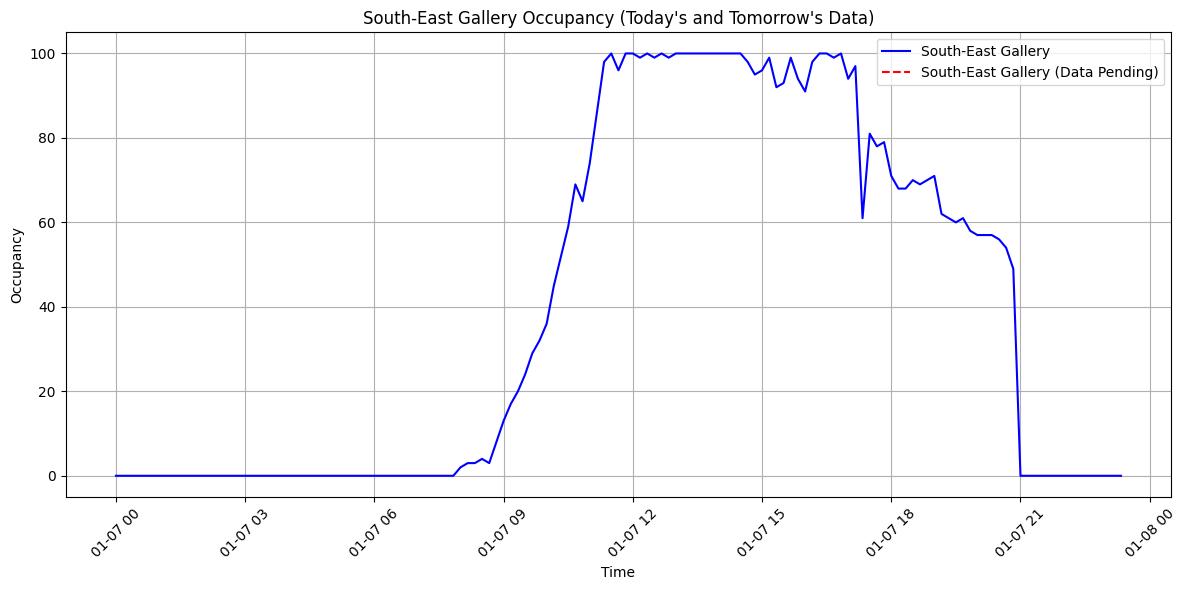

In [11]:

# Plot the data for today and tomorrow
plt.figure(figsize=(12, 6))
plt.plot(df_downloaded.index, df_downloaded['South-East Gallery'], label="South-East Gallery", color='blue')
plt.plot(df_null.index, df_null['South-East Gallery'], label="South-East Gallery (Data Pending)", color='red', linestyle='--')

plt.title("South-East Gallery Occupancy (Today's and Tomorrow's Data)")
plt.xlabel("Time")
plt.ylabel("Occupancy")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
df_today_tomorrow

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton
2025-01-07 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-07 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-07 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-07 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-07 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2025-01-08 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-08 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
import requests

def get_detailed_weather_forecast(latitude, longitude):
    """
    Fetches a detailed weather forecast for the remainder of the current day and the next 24 hours,
    with data points every 10 minutes created manually from hourly data.

    Parameters:
        latitude (float): Latitude of the location.
        longitude (float): Longitude of the location.

    Returns:
        pd.DataFrame: DataFrame containing the forecast data with 10-minute intervals.
    """
    url = "https://api.open-meteo.com/v1/forecast"

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": ["temperature_2m", "precipitation", "wind_speed_10m", "wind_direction_10m"],
        "forecast_days": 2,  # Ensures today and tomorrow are covered
        "timezone": "auto",
    }

    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()

    # Extract hourly data
    hourly_data = data.get('hourly', {})

    if not hourly_data:
        raise ValueError("No hourly data available in the API response.")

    weather_df = pd.DataFrame(hourly_data)

    # Convert time to datetime format
    if "time" in weather_df.columns:
        weather_df["time"] = pd.to_datetime(weather_df["time"], errors="coerce")
    else:
        raise KeyError("The 'time' column is missing in the hourly weather data.")

    # Set 'time' as the index
    weather_df.set_index("time", inplace=True)

    # Create 10-minute intervals
    detailed_weather_data = []
    for i in range(len(weather_df) - 1):
        start_row = weather_df.iloc[i]
        end_row = weather_df.iloc[i + 1]
        time_start = weather_df.index[i]
        time_end = weather_df.index[i + 1]

        # Generate intermediate 10-minute data
        time_range = pd.date_range(time_start, time_end, periods=7)[1:]
        for t in time_range:
            interpolated_row = {
                "time": t,
                "temperature_2m": start_row["temperature_2m"] + (end_row["temperature_2m"] - start_row["temperature_2m"]) * (t - time_start) / (time_end - time_start),
                "precipitation": start_row["precipitation"] + (end_row["precipitation"] - start_row["precipitation"]) * (t - time_start) / (time_end - time_start),
                "wind_speed_10m": start_row["wind_speed_10m"] + (end_row["wind_speed_10m"] - start_row["wind_speed_10m"]) * (t - time_start) / (time_end - time_start),
                "wind_direction_10m": start_row["wind_direction_10m"] + (end_row["wind_direction_10m"] - start_row["wind_direction_10m"]) * (t - time_start) / (time_end - time_start),
            }
            detailed_weather_data.append(interpolated_row)

    # Convert to DataFrame
    detailed_weather_df = pd.DataFrame(detailed_weather_data)
    detailed_weather_df.set_index("time", inplace=True)

    # Debug outputs
    print("Index type:", detailed_weather_df.index.dtype)
    print("Columns:", detailed_weather_df.columns)

    return detailed_weather_df

# Parameters
latitude, longitude = 59.3293, 18.0686  # Stockholm coordinates

# Get weather data for today and tomorrow, interpolated to 10-minute intervals
weather_data = get_detailed_weather_forecast(latitude, longitude)

# Print the merged and interpolated weather data for today and tomorrow
weather_data



Index type: datetime64[ns]
Columns: Index(['temperature_2m', 'precipitation', 'wind_speed_10m',
       'wind_direction_10m'],
      dtype='object')


,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m
time,,,,
2025-01-07 00:10:00,0.800000,0.966667,27.45,114.333333
2025-01-07 00:20:00,0.800000,0.933333,27.50,113.666667
2025-01-07 00:30:00,0.800000,0.900000,27.55,113.000000
2025-01-07 00:40:00,0.800000,0.866667,27.60,112.333333
2025-01-07 00:50:00,0.800000,0.833333,27.65,111.666667
...,...,...,...,...
2025-01-08 22:20:00,0.966667,0.000000,11.20,227.666667
2025-01-08 22:30:00,0.950000,0.000000,11.20,226.500000
2025-01-08 22:40:00,0.933333,0.000000,11.20,225.333333


In [14]:
# Step 2: Load the academic calendar dataset
repo_name_calendar = "andreitut/kth-academic-scraper"
hf_dataset_calendar = load_dataset(repo_name_calendar)

# Convert the calendar dataset to a DataFrame
df_calendar = pd.DataFrame(hf_dataset_calendar['train'])
df_calendar['Date'] = pd.to_datetime(df_calendar['Date'])

# Expand the calendar dataset to match the minute-level resolution
df_calendar_expanded = df_calendar.set_index('Date').reindex(df_seating_resampled.index.normalize(), method='ffill').reset_index()
df_calendar_expanded.rename(columns={'index': 'Date'}, inplace=True)
df_calendar_expanded

,Date,Year,Day of Year,Day of Week,Days Until Exam,Event
0,2024-12-09,2024,344,1,29,Normal
1,2024-12-09,2024,344,1,29,Normal
2,2024-12-09,2024,344,1,29,Normal
3,2024-12-09,2024,344,1,29,Normal
4,2024-12-09,2024,344,1,29,Normal
...,...,...,...,...,...,...
4203,2025-01-07,2025,7,2,0,Exam
4204,2025-01-07,2025,7,2,0,Exam
4205,2025-01-07,2025,7,2,0,Exam
4206,2025-01-07,2025,7,2,0,Exam


In [15]:
repo_name = "davnas/date_kth"

# Load the dataset from Hugging Face
hf_dataset = load_dataset(repo_name)

df_opening = pd.concat(
    [split.to_pandas() for split in hf_dataset.values()],
    ignore_index=True
)

# Set the index if the 'index' column exists
if 'index' in df_opening.columns:
    df_opening.set_index('index', inplace=True)

# Display the DataFrame
print(df_opening)


          date        day  opening_hour  closing_hour  is_open
0   2024-12-09     Monday            18            21        1
1   2024-12-10    Tuesday            10            21        1
2   2024-12-11  Wednesday             8            21        1
3   2024-12-12   Thursday             8            21        1
4   2024-12-13     Friday             8            18        1
5   2024-12-14   Saturday             0             0        0
6   2024-12-15     Sunday             0             0        0
7   2024-12-16     Monday            10            21        1
8   2024-12-17    Tuesday            10            21        1
9   2024-12-18  Wednesday             8            21        1
10  2024-12-19   Thursday             8            21        1
11  2024-12-20     Friday             8            19        1
12  2024-12-21   Saturday             0             0        0
13  2024-12-22     Sunday             0             0        0
14  2024-12-23     Monday            10            14  

### 2.2 Merge the Data


In [16]:
df_calendar_expanded

,Date,Year,Day of Year,Day of Week,Days Until Exam,Event
0,2024-12-09,2024,344,1,29,Normal
1,2024-12-09,2024,344,1,29,Normal
2,2024-12-09,2024,344,1,29,Normal
3,2024-12-09,2024,344,1,29,Normal
4,2024-12-09,2024,344,1,29,Normal
...,...,...,...,...,...,...
4203,2025-01-07,2025,7,2,0,Exam
4204,2025-01-07,2025,7,2,0,Exam
4205,2025-01-07,2025,7,2,0,Exam
4206,2025-01-07,2025,7,2,0,Exam


In [17]:
# Step 3: Merge the seating data with the expanded academic calendar
merged_seating_calendar = pd.merge_asof(
    df_null.sort_index(),
    df_calendar_expanded.sort_values('Date'),
    left_index=True,
    right_on='Date'
)
# Visualize Step 3: Merged seating and calendar data
print("Step 3: Merged seating data with academic calendar")

merged_seating_calendar

Step 3: Merged seating data with academic calendar


,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Date,Year,Day of Year,Day of Week,Days Until Exam,Event
2025-01-07 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-07,2025,7,2,0,Exam
2025-01-07 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-07,2025,7,2,0,Exam
2025-01-07 23:50:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-07,2025,7,2,0,Exam
2025-01-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-07,2025,7,2,0,Exam
2025-01-08 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-07,2025,7,2,0,Exam
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-08 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-07,2025,7,2,0,Exam
2025-01-08 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-07,2025,7,2,0,Exam
2025-01-08 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-07,2025,7,2,0,Exam
2025-01-08 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-07,2025,7,2,0,Exam


In [18]:
# Merge historical weather data with the merged dataset
merge_seat_academic_weather = pd.merge_asof(
    merged_seating_calendar.sort_index(),
    weather_data.sort_index(),
    left_index=True,
    right_index=True,
    direction='forward'
)
merge_seat_academic_weather.drop(columns=['Date', 'Year'], inplace=True)
merge_seat_academic_weather

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m
2025-01-07 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,2.65,0.0,23.000000,188.500000
2025-01-07 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,2.60,0.0,22.400000,188.333333
2025-01-07 23:50:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,2.55,0.0,21.800000,188.166667
2025-01-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,2.50,0.0,21.200000,188.000000
2025-01-08 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,2.45,0.0,20.483333,187.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-08 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,NaN,NaN,NaN,NaN
2025-01-08 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,NaN,NaN,NaN,NaN
2025-01-08 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,NaN,NaN,NaN,NaN
2025-01-08 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,NaN,NaN,NaN,NaN


In [19]:
# Convert the 'date' column in df_opening to datetime to match the index of merge_seat_academic_weather
df_opening['date'] = pd.to_datetime(df_opening['date'])

# Merge on the date index while ensuring time-specific data aligns properly
merged_final = pd.merge_asof(
    merge_seat_academic_weather.reset_index(),
    df_opening,
    left_on='index',
    right_on='date',
    direction='backward'
).set_index('index')

# Drop unnecessary columns if needed (like duplicate 'date' column)
merged_final.drop(columns=['date'], inplace=True)

In [20]:
# 4. Remove the last 10 entries if needed
df_resampled = merged_final.copy()
df_resampled = df_resampled[:-10]
df_resampled.to_csv('merged_future.csv')
df_resampled

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,day,opening_hour,closing_hour,is_open
index,,,,,,,,,,,,,,,,,,
2025-01-07 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,2.650000,0.0,23.000000,188.500000,Tuesday,8,21,1
2025-01-07 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,2.600000,0.0,22.400000,188.333333,Tuesday,8,21,1
2025-01-07 23:50:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,2.550000,0.0,21.800000,188.166667,Tuesday,8,21,1
2025-01-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,2.500000,0.0,21.200000,188.000000,Wednesday,8,21,1
2025-01-08 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,2.450000,0.0,20.483333,187.166667,Wednesday,8,21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-08 21:30:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,1.150000,0.0,11.700000,236.000000,Wednesday,8,21,1
2025-01-08 21:40:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,1.100000,0.0,11.533333,234.000000,Wednesday,8,21,1
2025-01-08 21:50:00,NaN,NaN,NaN,NaN,NaN,NaN,7,2,0,Exam,1.050000,0.0,11.366667,232.000000,Wednesday,8,21,1


## 2.3 Inference


In [21]:
from huggingface_hub import login # Import the login function
from huggingface_hub import hf_hub_download, HfApi

In [22]:
from utils import preprocess_raw_data
print("Import successful!")


Import successful!


Model for KTH Library loaded successfully
Model for South-East Gallery loaded successfully
Model for North Gallery loaded successfully
Model for South Gallery loaded successfully
Model for Ångdomen loaded successfully
Model for Newton loaded successfully


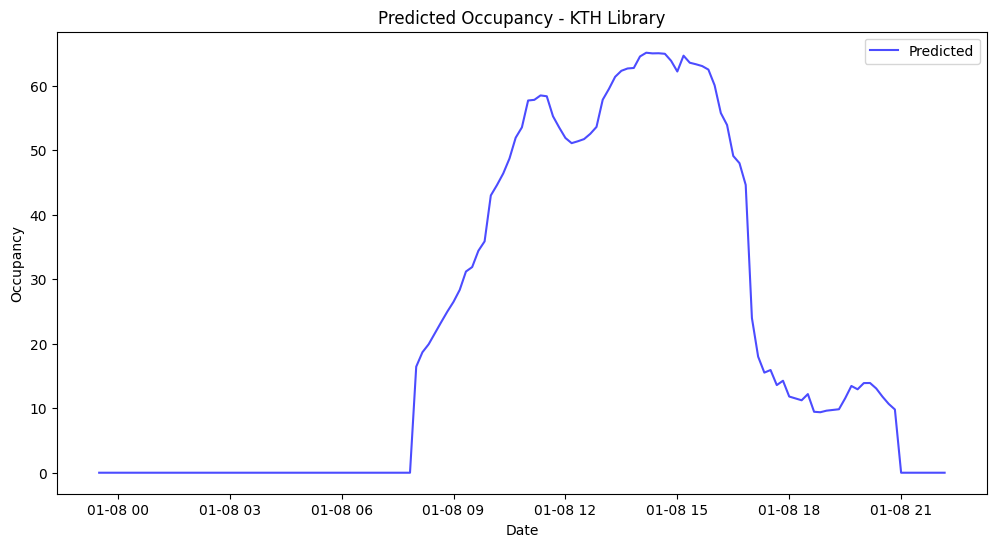

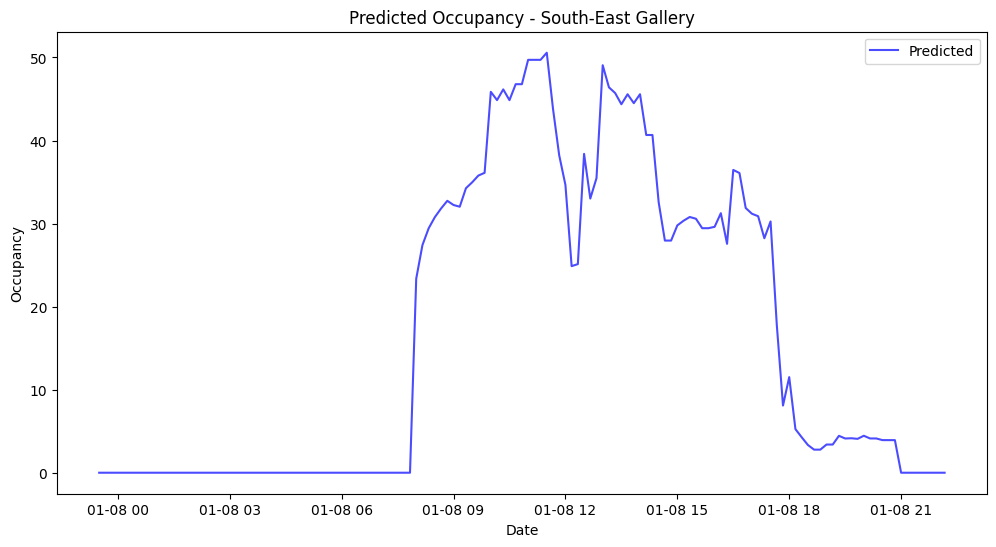

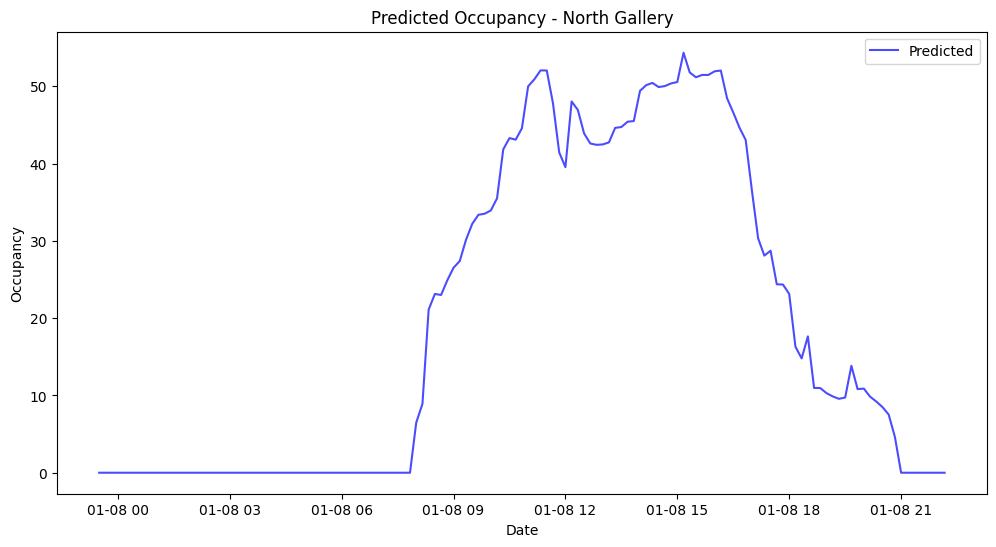

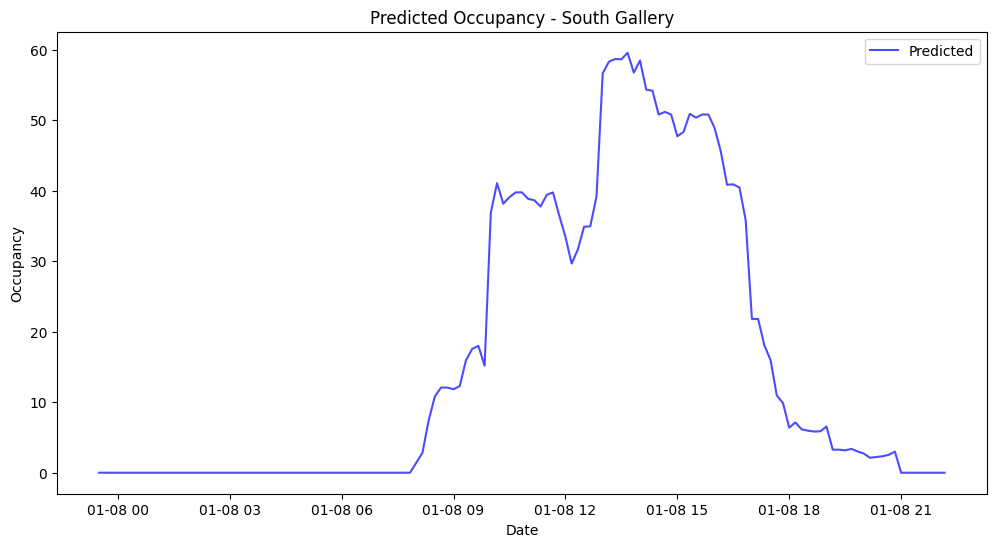

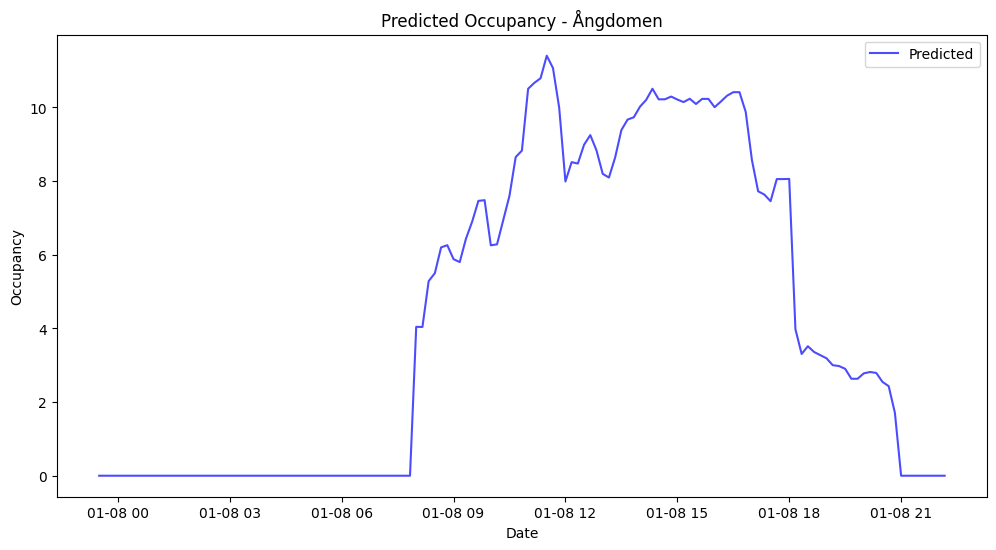

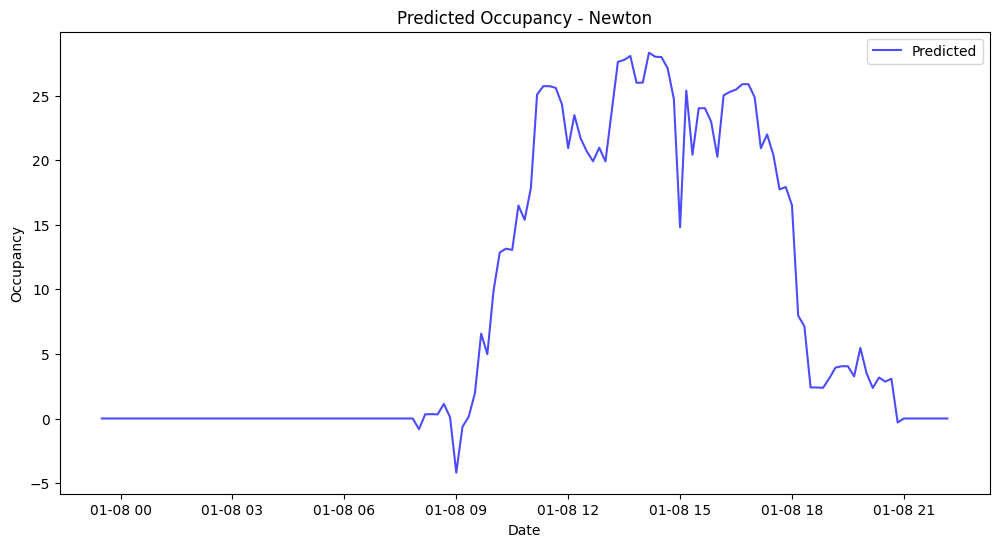

In [23]:
import joblib

future_df = df_resampled.copy()
future_df = preprocess_raw_data(future_df)
locations = ['KTH Library', 'South-East Gallery', 'North Gallery', 'South Gallery',
       'Ångdomen', 'Newton']  # Add all your locations
# Load models from Hugging Face

repo_name = "davnas/library_model"
loaded_models = load_models_from_huggingface(locations, repo_name, HUGGINGFACE_TOKEN)

# Use loaded models for prediction
future_predictions = predict_future(loaded_models, future_df)

In [24]:
# Make predictions and format them
predictions_df = predict_and_format(loaded_models, future_df)

# View the results
print("Predictions shape:", predictions_df.shape)
print("\nFirst few predictions:")
print(predictions_df.head())


Predictions shape: (137, 6)

First few predictions:
                     KTH Library  South-East Gallery  North Gallery  \
index                                                                 
2025-01-07 23:30:00          0.0                 0.0            0.0   
2025-01-07 23:40:00          0.0                 0.0            0.0   
2025-01-07 23:50:00          0.0                 0.0            0.0   
2025-01-08 00:00:00          0.0                 0.0            0.0   
2025-01-08 00:10:00          0.0                 0.0            0.0   

                     South Gallery  Ångdomen  Newton  
index                                                 
2025-01-07 23:30:00            0.0       0.0     0.0  
2025-01-07 23:40:00            0.0       0.0     0.0  
2025-01-07 23:50:00            0.0       0.0     0.0  
2025-01-08 00:00:00            0.0       0.0     0.0  
2025-01-08 00:10:00            0.0       0.0     0.0  


In [25]:
# prompt: format predictions_df with int as columns
# Convert columns to integers, handling potential errors
for col in predictions_df.columns:
    try:
        predictions_df[col] = predictions_df[col].astype(int)
    except ValueError:
        print(f"Warning: Could not convert column '{col}' to integer type.  Values might not be purely numeric.")
        # Handle the non-numeric values appropriately (e.g., fillna, replace with a default)
        predictions_df[col] = predictions_df[col].fillna(0).astype(int) #Example: Fill NaN with 0 then convert




## 2.4 Combining the past and future

In [26]:
df_past = df_downloaded.copy()
df_past['prediction'] = 0
df_past.reset_index(inplace=True)

df_past

,index,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,prediction
0,2025-01-07 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2025-01-07 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2025-01-07 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2025-01-07 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2025-01-07 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
136,2025-01-07 22:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0
137,2025-01-07 22:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0
138,2025-01-07 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
139,2025-01-07 23:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0


In [27]:
df_future = predictions_df.copy()
df_future['prediction'] = 1
df_future.reset_index(inplace=True)


In [28]:
df_full = pd.concat([df_past, df_future])
df_full
df_full

,index,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,prediction
0,2025-01-07 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2025-01-07 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2025-01-07 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2025-01-07 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2025-01-07 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
132,2025-01-08 21:30:00,0.0,0.0,0.0,0.0,0.0,0.0,1
133,2025-01-08 21:40:00,0.0,0.0,0.0,0.0,0.0,0.0,1
134,2025-01-08 21:50:00,0.0,0.0,0.0,0.0,0.0,0.0,1
135,2025-01-08 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1


In [29]:
df_full = df_full.rename(columns={'index': 'ds'})
df_full

,ds,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,prediction
0,2025-01-07 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2025-01-07 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2025-01-07 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2025-01-07 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2025-01-07 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
132,2025-01-08 21:30:00,0.0,0.0,0.0,0.0,0.0,0.0,1
133,2025-01-08 21:40:00,0.0,0.0,0.0,0.0,0.0,0.0,1
134,2025-01-08 21:50:00,0.0,0.0,0.0,0.0,0.0,0.0,1
135,2025-01-08 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1


## 2.5 Plotting

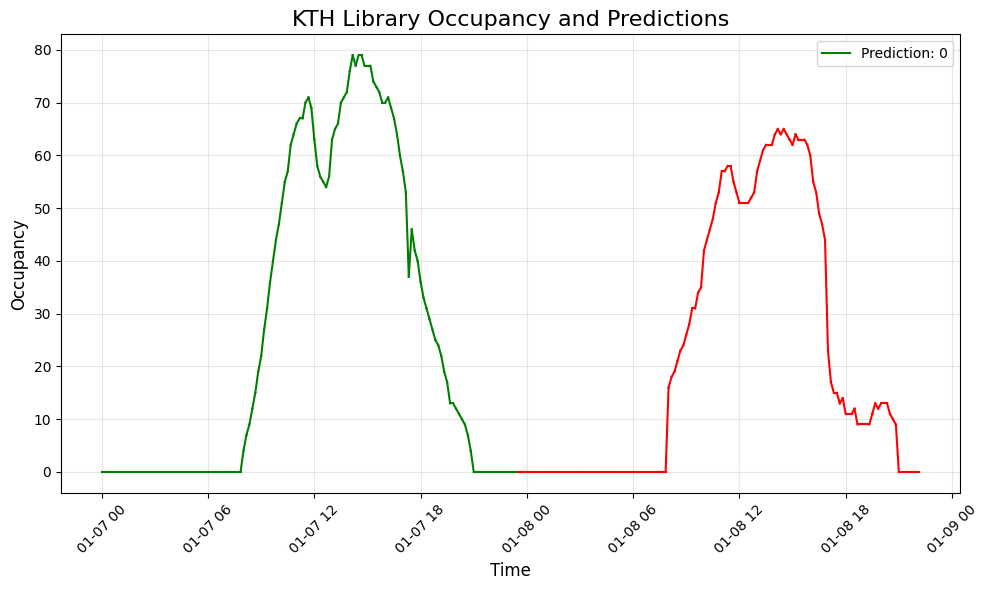

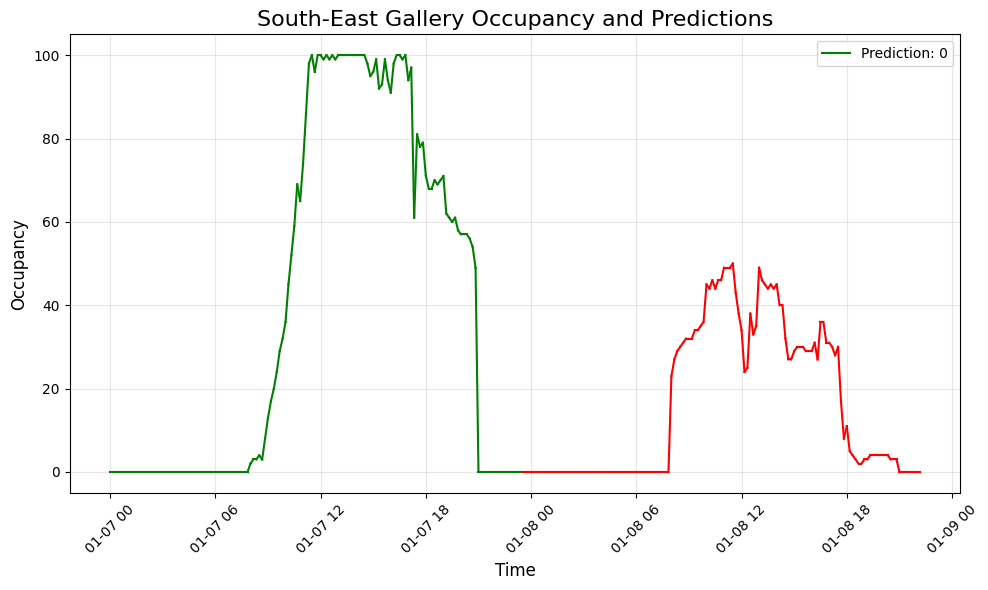

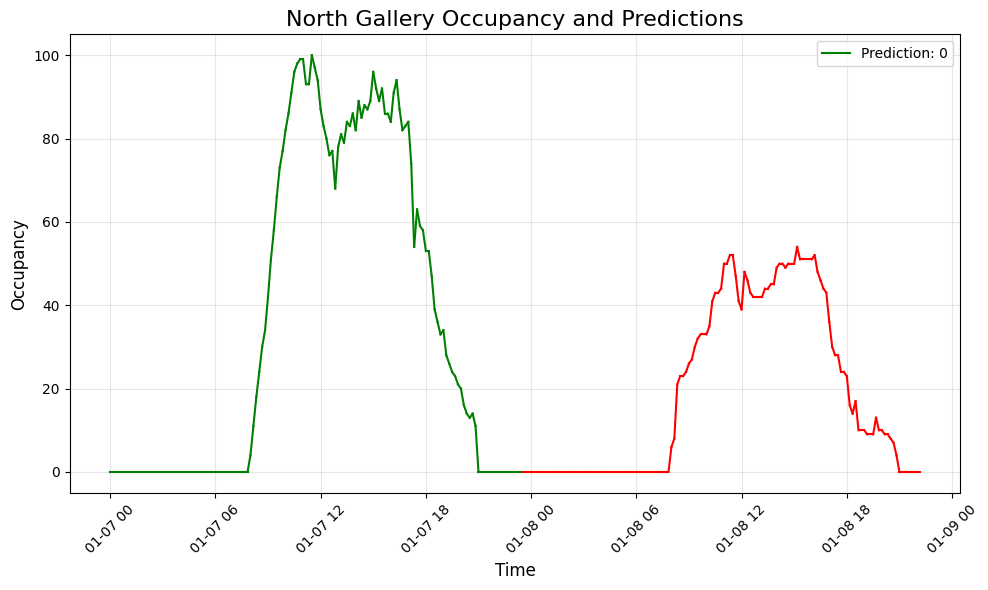

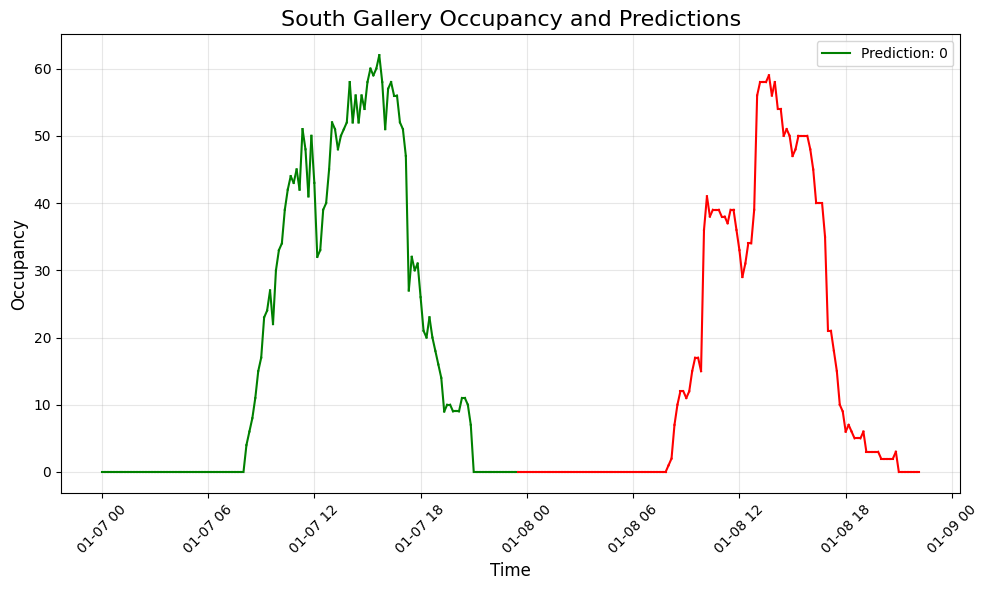

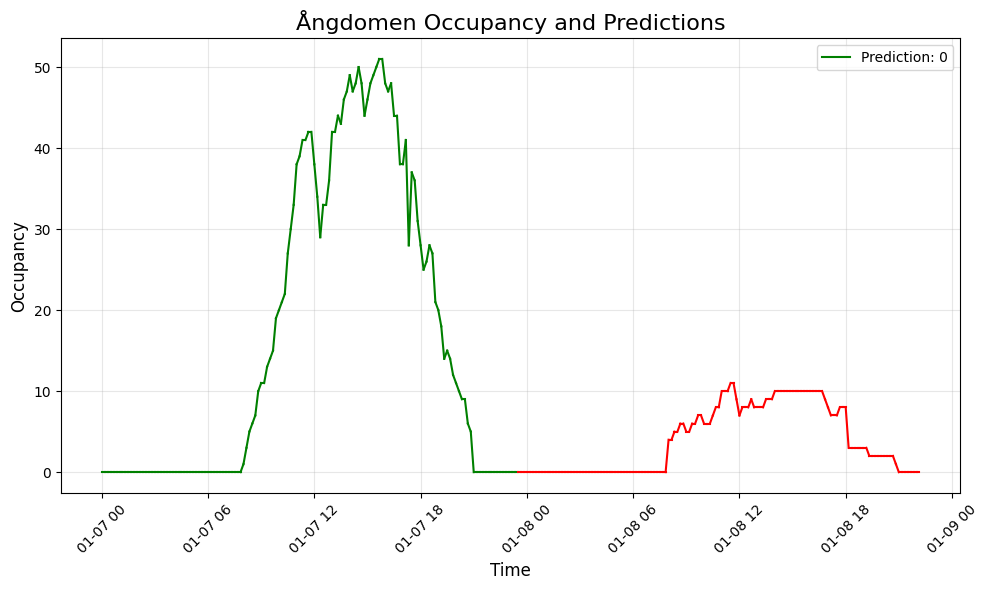

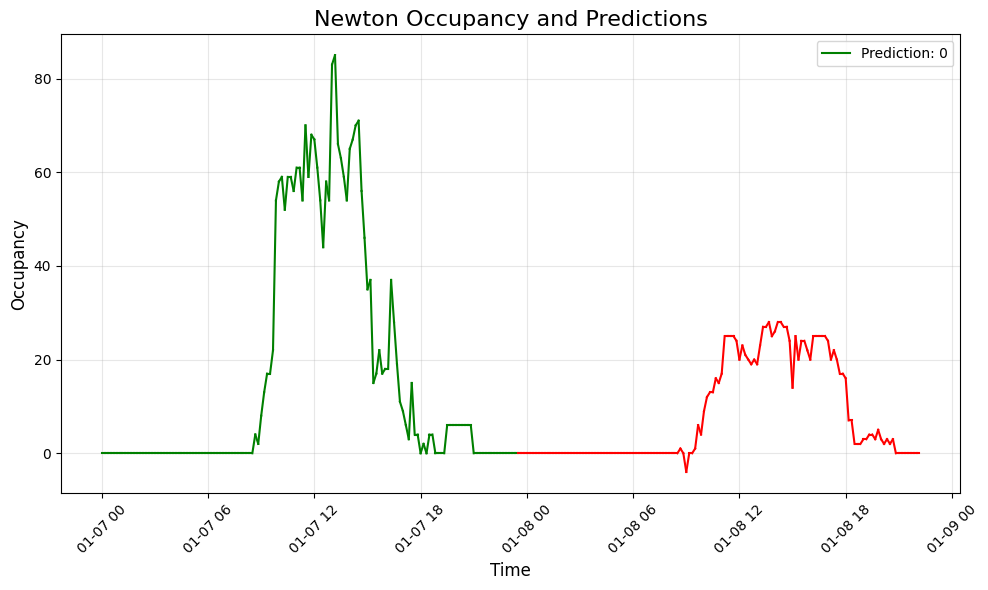

In [30]:
# Ensure the 'ds' column exists and is datetime
if 'ds' not in df_full.columns:
    raise KeyError("'ds' column is missing from the DataFrame.")

# Plot each location in a separate figure
locations = ['KTH Library', 'South-East Gallery', 'North Gallery', 'South Gallery', 'Ångdomen', 'Newton']

for location in locations:
    plt.figure(figsize=(10, 6))

    # Iterate through the DataFrame rows and plot segments based on prediction
    for i in range(len(df_full) - 1):
        color = 'green' if df_full['prediction'].iloc[i] == 0 else 'red'
        plt.plot(
            df_full['ds'].iloc[i:i+2],  # X-axis
            df_full[location].iloc[i:i+2],  # Y-axis
            color=color, label=f'Prediction: {df_full["prediction"].iloc[i]}' if i == 0 else ""
        )

    plt.title(f"{location} Occupancy and Predictions", fontsize=16)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Occupancy", fontsize=12)
    plt.legend(loc="upper right")
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Show each plot
    plt.show()

## 2.6 Pushing


In [31]:
import pandas as pd
from datetime import timedelta

# Ensure 'ds' is localized correctly
if df_full['ds'].dt.tz is None:
    df_full['ds'] = df_full['ds'].dt.tz_localize('UTC')  # Localize as UTC

# Remove timezone if you want naive timestamps
df_full['ds'] = df_full['ds'].dt.tz_convert(None)


In [32]:
# Get today's normalized date
today_date = pd.Timestamp.now().normalize()

# Filter for today's data
df_today = df_full[(df_full['ds'] >= today_date) & (df_full['ds'] < today_date + timedelta(days=1))]

# Resample as needed
df_today_resampled = (
    df_today.set_index('ds')
    .resample('30T')
    .mean()
    .reset_index()
)

# Define time range
start_time = today_date + timedelta(hours=7, minutes=30)
end_time = today_date + timedelta(hours=21, minutes=30)

# Reindex to fill gaps
time_range = pd.date_range(start=start_time, end=end_time, freq='30T')
df_today_resampled = (
    df_today_resampled
    .set_index('ds')
    .reindex(time_range)
    .reset_index()
    .rename(columns={'index': 'ds'})
)

df_today_resampled

,ds,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,prediction
0,2025-01-07 07:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,2025-01-07 08:00:00,6.666667,2.666667,11.000000,3.333333,3.000000,0.000000,0.0
2,2025-01-07 08:30:00,15.333333,5.000000,29.333333,11.333333,7.666667,2.000000,0.0
3,2025-01-07 09:00:00,26.666667,16.666667,50.333333,21.333333,11.666667,12.666667,0.0
4,2025-01-07 09:30:00,40.000000,28.333333,72.000000,26.333333,16.000000,31.000000,0.0
5,2025-01-07 10:00:00,51.000000,44.333333,86.333333,35.333333,21.000000,56.333333,0.0
6,2025-01-07 10:30:00,61.000000,64.333333,97.666667,43.000000,30.000000,58.000000,0.0
7,2025-01-07 11:00:00,66.666667,86.000000,95.000000,46.000000,39.333333,58.666667,0.0
8,2025-01-07 11:30:00,70.000000,98.666667,97.000000,46.333333,41.666667,65.666667,0.0
9,2025-01-07 12:00:00,59.000000,99.666667,83.333333,36.000000,33.666667,60.666667,0.0


In [33]:
# Get tomorrow's normalized date
tomorrow_date = (pd.Timestamp.now() + timedelta(days=1)).normalize()

# Filter for tomorrow's data
df_tomorrow = df_full[(df_full['ds'] >= tomorrow_date) & (df_full['ds'] < tomorrow_date + timedelta(days=1))]

# Resample as needed
df_tomorrow_resampled = (
    df_tomorrow.set_index('ds')
    .resample('30T')
    .mean()
    .reset_index()
)

# Define time range
start_time = tomorrow_date + timedelta(hours=7, minutes=30)
end_time = tomorrow_date + timedelta(hours=21, minutes=30)

# Reindex to fill gaps
time_range = pd.date_range(start=start_time, end=end_time, freq='30T')
df_tomorrow_resampled = (
    df_tomorrow_resampled
    .set_index('ds')
    .reindex(time_range)
    .reset_index()
    .rename(columns={'index': 'ds'})
)

df_tomorrow_resampled

,ds,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,prediction
0,2025-01-08 07:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
1,2025-01-08 08:00:00,17.666667,26.333333,11.666667,3.333333,4.333333,0.000000,1.0
2,2025-01-08 08:30:00,22.666667,31.000000,23.333333,11.333333,5.666667,0.333333,1.0
3,2025-01-08 09:00:00,28.333333,32.666667,27.666667,12.666667,5.333333,-1.333333,1.0
4,2025-01-08 09:30:00,33.333333,35.000000,32.666667,16.333333,6.666667,3.666667,1.0
5,2025-01-08 10:00:00,44.000000,45.000000,36.333333,38.333333,6.000000,11.333333,1.0
6,2025-01-08 10:30:00,50.666667,45.333333,43.333333,39.000000,7.666667,14.666667,1.0
7,2025-01-08 11:00:00,57.333333,49.000000,50.666667,37.666667,10.000000,22.333333,1.0
8,2025-01-08 11:30:00,55.333333,43.666667,46.666667,38.000000,10.333333,24.666667,1.0
9,2025-01-08 12:00:00,51.000000,27.666667,44.333333,31.000000,7.666667,21.333333,1.0


In [34]:
# Convert all occupancy values to integers
occupancy_columns = ['KTH Library', 'South-East Gallery', 'North Gallery', 'South Gallery', 'Ångdomen', 'Newton']
df_today_resampled[occupancy_columns] = df_today_resampled[occupancy_columns].fillna(0).astype(int)
df_tomorrow_resampled[occupancy_columns] = df_tomorrow_resampled[occupancy_columns].fillna(0).astype(int)

In [35]:
df_tomorrow_resampled

,ds,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,prediction
0,2025-01-08 07:30:00,0,0,0,0,0,0,1.0
1,2025-01-08 08:00:00,17,26,11,3,4,0,1.0
2,2025-01-08 08:30:00,22,31,23,11,5,0,1.0
3,2025-01-08 09:00:00,28,32,27,12,5,-1,1.0
4,2025-01-08 09:30:00,33,35,32,16,6,3,1.0
5,2025-01-08 10:00:00,44,45,36,38,6,11,1.0
6,2025-01-08 10:30:00,50,45,43,39,7,14,1.0
7,2025-01-08 11:00:00,57,49,50,37,10,22,1.0
8,2025-01-08 11:30:00,55,43,46,38,10,24,1.0
9,2025-01-08 12:00:00,51,27,44,31,7,21,1.0


In [36]:
from datetime import datetime, timedelta # Import datetime and timedelta

# Add the required columns for CommitTime and Time
current_time = datetime.now()

commit_time = (current_time + timedelta(hours=1)).strftime("%Y-%m-%d %H:%M:%S")
df_today_resampled['CommitTime'] = commit_time
df_tomorrow_resampled['CommitTime'] = commit_time

df_today_resampled['Time'] = df_today_resampled['ds'].dt.strftime('%H:%M')
df_tomorrow_resampled['Time'] = df_tomorrow_resampled['ds'].dt.strftime('%H:%M')

# Rename columns to match the required format
df_today_resampled = df_today_resampled.rename(columns={
    'KTH Library': 'Occupancy_main',
    'South-East Gallery': 'Occupancy_southEast',
    'North Gallery': 'Occupancy_north',
    'South Gallery': 'Occupancy_south',
    'Ångdomen': 'Occupancy_angdomen',
    'Newton': 'Occupancy_newton'
})

df_tomorrow_resampled = df_tomorrow_resampled.rename(columns={
    'KTH Library': 'Occupancy_main',
    'South-East Gallery': 'Occupancy_southEast',
    'North Gallery': 'Occupancy_north',
    'South Gallery': 'Occupancy_south',
    'Ångdomen': 'Occupancy_angdomen',
    'Newton': 'Occupancy_newton'
})

# Reorder columns
df_today_resampled = df_today_resampled[
    ['CommitTime', 'Time', 'Occupancy_main', 'Occupancy_southEast', 'Occupancy_north',
     'Occupancy_south', 'Occupancy_angdomen', 'Occupancy_newton']
]

df_tomorrow_resampled = df_tomorrow_resampled[
    ['CommitTime', 'Time', 'Occupancy_main', 'Occupancy_southEast', 'Occupancy_north',
     'Occupancy_south', 'Occupancy_angdomen', 'Occupancy_newton']
]


In [37]:
#df_tomorrow_resampled

In [38]:
#df_today_resampled

In [39]:
# Save to CSV
df_tomorrow_resampled.to_csv('tomorrow_resampled.csv', index=False)

# Display the first few rows of the DataFrame
print(df_today_resampled.tail())

             CommitTime   Time  Occupancy_main  Occupancy_southEast  \
24  2025-01-08 00:41:25  19:30              14                   59   
25  2025-01-08 00:41:25  20:00              11                   57   
26  2025-01-08 00:41:25  20:30               6                   53   
27  2025-01-08 00:41:25  21:00               0                    0   
28  2025-01-08 00:41:25  21:30               0                    0   

    Occupancy_north  Occupancy_south  Occupancy_angdomen  Occupancy_newton  
24               22                9                  13                 6  
25               16                9                  10                 6  
26               12                9                   6                 6  
27                0                0                   0                 0  
28                0                0                   0                 0  


In [40]:
# Save to CSV
df_today_resampled.to_csv('occupancy_today.csv', index=False)

# Display the first few rows of the DataFrame
print(df_today_resampled.tail())

             CommitTime   Time  Occupancy_main  Occupancy_southEast  \
24  2025-01-08 00:41:25  19:30              14                   59   
25  2025-01-08 00:41:25  20:00              11                   57   
26  2025-01-08 00:41:25  20:30               6                   53   
27  2025-01-08 00:41:25  21:00               0                    0   
28  2025-01-08 00:41:25  21:30               0                    0   

    Occupancy_north  Occupancy_south  Occupancy_angdomen  Occupancy_newton  
24               22                9                  13                 6  
25               16                9                  10                 6  
26               12                9                   6                 6  
27                0                0                   0                 0  
28                0                0                   0                 0  


In [41]:
import pandas as pd


csv_file_path = "occupancy_today.csv"
csv_file_path_1 = "tomorrow_resampled.csv"

from huggingface_hub import HfApi, HfFolder

# Hugging Face token and repository details
repo_name = "davnas/library-occupancy"  # Replace with your repository name
#csv_file_path = "data.csv"  # Replace with your CSV file path

# Authenticate using the token
HfFolder.save_token(HUGGINGFACE_TOKEN)
api = HfApi()

# Upload the CSV file
api.upload_file(
    path_or_fileobj=csv_file_path,
    path_in_repo="data_2.csv",  # The name of the file in the repository
    repo_id=repo_name,
    repo_type="dataset",  # Indicates this is a dataset repository
    token=HUGGINGFACE_TOKEN
)

api.upload_file(
    path_or_fileobj=csv_file_path_1,
    path_in_repo="forecast_tomorrow.csv",  # The name of the file in the repository
    repo_id=repo_name,
    repo_type="dataset",  # Indicates this is a dataset repository
    token=HUGGINGFACE_TOKEN
)

print(f"CSV file successfully uploaded to Hugging Face repository: {repo_name}")



CSV file successfully uploaded to Hugging Face repository: davnas/library-occupancy
